X =  [[ 1.0000000e+00  0.0000000e+00]
 [ 6.1232340e-17  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16]
 [-1.8369702e-16 -1.0000000e+00]]


loss = 11.288174629211426:   0%|          | 4/1000 [00:00<00:25, 39.17it/s]

Training


loss = 1.1212856769561768: 100%|██████████| 1000/1000 [00:25<00:00, 39.84it/s]


Testing


CE = 1.1008154153823853: 100%|██████████| 500/500 [02:33<00:00,  3.26it/s]


sigma2 =  3.1622776601683795
CE true =  0.9239850368451656
CE Inner =  0.9239850368451656


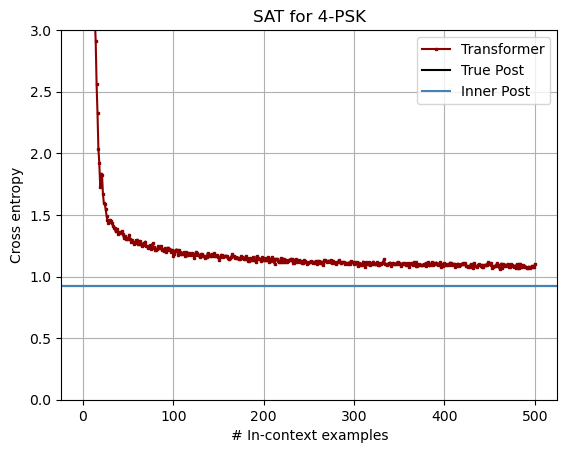

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import math


def gen_time_invariant_process(X,
                            max_context_len=10,
                            batch_size=100,
                            d=4,
                            SNR_dB=-5,
                            channel_power=1/2):
    """
    inputs --
        X: input symbs set of size |X| x din = 2
        latent: corresponding to which the prompt is degenerated
        max_context_len:
    returns --
        x: (batchsize, max_cnxt_ln, 1)
        y: (batchsize, max_cnxt_ln, d)
        h: (batchsize, d)
    """

    sigma2 = 10**(-SNR_dB/10)
    sigma = np.sqrt(sigma2)
    channel_amp = np.sqrt(channel_power)
    hI, hQ = channel_amp*np.random.randn(batch_size, 1, d), channel_amp*np.random.randn(batch_size, 1, d)
    h = hI + 1j*hQ
    zI, zQ = sigma*np.random.randn(batch_size, max_context_len, d), sigma*np.random.randn(batch_size, max_context_len, d)
    z = zI + 1j*zQ  
    s =  np.random.choice(len(X), size=(batch_size, max_context_len), replace=True)
    x_vec = X[s]
    xI, xQ = x_vec[:,:,0], x_vec[:,:,1]
    x = (xI + 1j * xQ).reshape(batch_size, max_context_len, 1)
    y = x * h + z
    yI, yQ = np.real(y), np.imag(y)
    y_vec = np.concatenate((yI, yQ), axis=-1)
    y_past = torch.from_numpy(y_vec[:,:-1,:]).float()
    y_q = torch.from_numpy(y_vec[:,-1,:]).unsqueeze(1).float()
    sig = torch.from_numpy(s[:,:-1])
    s_q = torch.from_numpy(s[:,-1])


    H1 = np.concatenate((hI, hQ), axis=-1) # 1, 2d
    H2 = np.concatenate((-hQ, hI), axis=-1)  # 1, 2d
    H = np.concatenate((H1, H2), axis=-2).transpose((0,2,1)) # b, 2d, 2 after T

    return y_past, y_q, sig, s_q, H


class SAT(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.d = d
        self.W = torch.nn.Parameter(torch.randn(size=(2*d,2*d)))

    def forward(self, sig, y_q, y_past, S):
        """
        sig: b, n
        y_q: b, 1, d
        y_past: b, n, d
        
        """
        b, n, d = y_past.shape

        e_s = torch.eye(S)[sig]  # b, n, S

        y_past_T = torch.transpose(y_past, 2, 1)  # b, d, n

        score_logits = (y_q @ self.W @ y_past_T).squeeze(1)  # b, n

        attn_scores = F.softmax(score_logits, dim=-1).unsqueeze(-1)  # b, n, 1

        post_est =  torch.sum(attn_scores * e_s, dim=1)  # b, S

        return post_est
    

def true_post_est(y_q, H, SNR_dB, X):

    """
    y_q: b, 1, 2d
    H: b, 2d, 2
    X: S, 2
    """
    sigma2 = 10**(-SNR_dB/10)
    print('sigma2 = ', sigma2)
    y_q = y_q.numpy()

    y_q_T = y_q.transpose((0,2,1))
    Hx = H @ X.T
    # print('yqt = ', y_q_T.shape)
    # print('Hx = ', Hx.shape)
    scores = np.sum(-np.abs(y_q_T - Hx)**2, axis=1) / sigma2 / 2  # b, S

    scores_true = torch.from_numpy(scores)
    true_post = torch.softmax(scores_true, dim=-1)

    # print('scores = ', scores.shape)

    scores_inner_np = (y_q @ H @ X.T).squeeze(1) / sigma2  # b, S
    scores_inner = torch.from_numpy(scores_inner_np)
    
    inner_post = torch.softmax(scores_inner, dim=-1)
    return true_post, inner_post

def cross_entropy(input_dist, tar, tol=1e-30):
    """
    tar: b,
    input_dist: b, S
    """
    input_dist_reg = (input_dist + tol)
    return torch.mean(-torch.log(input_dist_reg[torch.arange(len(tar)), tar]))



def train(model, X, batch_size=128, SNR_dB = -5, d=4, max_context_len=50, n_epochs=10000):

    opt = torch.optim.Adam(model.parameters(), lr=0.05)
    S = len(X)

    pbar = tqdm(range(n_epochs))
    print('Training')

    for t in pbar:

        y_past, y_q, sig, s_q, _ = gen_time_invariant_process(X=X, 
                                                                batch_size=batch_size, 
                                                                SNR_dB=SNR_dB, 
                                                                d=d, 
                                                                max_context_len=max_context_len+1)
        post_est = model(sig=sig, y_past=y_past, y_q=y_q, S=S)
        loss = cross_entropy(input_dist=post_est, tar=s_q)  # cross entropy
        opt.zero_grad()
        loss.backward()
        opt.step()
        pbar.set_description(f'loss = {loss}')

    torch.save(model.state_dict(), 'SavedModels/model.pt')
    return model

def test(model, X, batch_size=128, SNR_dB = -5, d=4, max_context_len=50):

    CE_model = np.zeros(max_context_len)

    print('Testing')

    
    pbar = tqdm(range(max_context_len))
    for i in pbar:
        y_past, y_q, sig, s_q, _ = gen_time_invariant_process(X=X, 
                                                        batch_size=batch_size, 
                                                        SNR_dB=SNR_dB, 
                                                        d=d, 
                                                        max_context_len=i+2)
        
        post_est = model(sig=sig, y_past=y_past, y_q=y_q, S=S)
        CE = cross_entropy(input_dist=post_est, tar=s_q)
        CE_model[i] = CE.detach().numpy()
        pbar.set_description(f'CE = {CE_model[i]}')

    return CE_model


def gen_PSK(S=4):
    sig_real = np.cos(np.arange(S) * 2 * np.pi / S)
    sig_imag = np.atleast_2d(np.sin(np.arange(S) * 2 * np.pi / S))
    sig_set = np.vstack((sig_real, sig_imag)).T
    return sig_set


def gen_QAM(S=16):

    M_real = math.sqrt(S)

    sig_real_pos = torch.arange(M_real)
    sig_real_mean = torch.mean(sig_real_pos)
    sig_real = sig_real_pos - sig_real_mean

    sig_real_2D = sig_real.unsqueeze(0)
    sig_real_2D =  sig_real_2D.repeat((int(M_real),1))

    sig_imag_2D = sig_real_2D.transpose(0,1)
    sig_imag_2D = torch.flip(sig_imag_2D, dims=[0]).flatten().unsqueeze(-1)

    sig_real_2D = sig_real_2D.flatten().unsqueeze(-1)
    sig_set = torch.cat((sig_real_2D, sig_imag_2D), dim=-1)
    power = torch.mean(sig_set[:, 0]**2 + sig_set[:, 1]**2)
    unit_sig_set = sig_set / math.sqrt(power)
    power_after_norm = torch.mean(unit_sig_set[:, 0]**2 + unit_sig_set[:, 1]**2)
    print('power after norm = ', power_after_norm)
    sig_set_np = unit_sig_set.numpy()
    return sig_set_np

def gen_sig(S=16, type='QAM'):
    if type == 'PSK':
        return gen_PSK(S=S)
    else:
        return gen_QAM(S=S)

    

n_epochs = 1000
SNR_dB = -5
batch_size=128
max_context_len = 700
d = 4
S = 4
sig_type='PSK'
X = gen_sig(S=S, type=sig_type)

print('X = ', X)

# X = np.array([[1,1],[1,-1],[-1,1],[-1,-1]])
S = len(X)

my_SAT = SAT(d=d) 
train(model=my_SAT, X=X, batch_size=batch_size, SNR_dB=SNR_dB, d=d, max_context_len=max_context_len, n_epochs=n_epochs)

n_samples = 5000
test_max_context_len = 500

CE_model = test(model=my_SAT, X=X, batch_size=n_samples, SNR_dB=SNR_dB, d=d, max_context_len=test_max_context_len)


n_samples_true = 50000
y_past, y_q, sig, s_q, H = gen_time_invariant_process(X=X, 
                                                    batch_size=n_samples_true, 
                                                    d=d, 
                                                    max_context_len=3, 
                                                    SNR_dB=SNR_dB)


true_post, inner_post = true_post_est(y_q=y_q, H=H, SNR_dB=SNR_dB, X=X)  # does not depend on y_past
CE_true = cross_entropy(input_dist=true_post, tar=s_q, tol=0).detach().numpy()
CE_inner = cross_entropy(input_dist=inner_post, tar=s_q, tol=0).detach().numpy()

print('CE true = ', CE_true)
print('CE Inner = ', CE_inner)

n_in_context_examples = np.arange(1, test_max_context_len+1)

plt.plot(n_in_context_examples, CE_model, label='Transformer', marker='s',  markersize=2, color='darkred', lw=1.5)
plt.axhline(y = CE_true, color = 'k', linestyle = '-', label='True Post', lw=1.5) 
# plt.axhline(y = CE_inner, color = 'steelblue', linestyle = '-', label='Inner Post', lw=1.5) 
plt.xlabel("# In-context examples")
plt.ylabel("Cross entropy")
plt.ylim([0,3])
plt.legend()
plt.grid()
plt.title(f"SAT for {S}-{sig_type}")
plt.savefig(f"Figures/SingleLayerSATConvergenceInnerLims_M_{test_max_context_len}_N_{max_context_len}_S_{S}-{sig_type}.png", bbox_inches='tight', dpi=400)




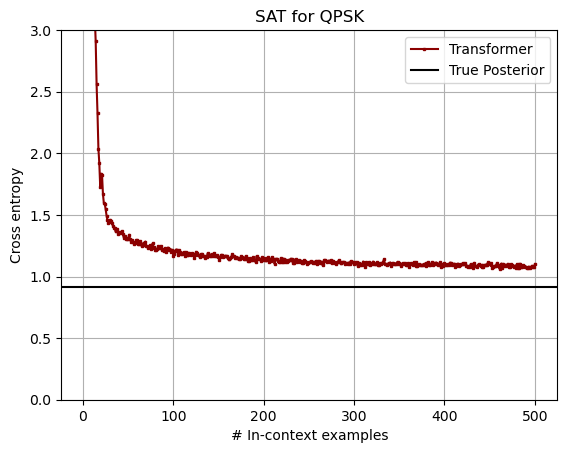

In [12]:
plt.plot(n_in_context_examples, CE_model, label='Transformer', marker='s',  markersize=2, color='darkred', lw=1.5)
plt.axhline(y = CE_true, color = 'k', linestyle = '-', label='True Posterior', lw=1.5) 
# plt.axhline(y = CE_inner, color = 'steelblue', linestyle = '-', label='Inner Posterior', lw=1.5) 
plt.xlabel("# In-context examples")
plt.ylabel("Cross entropy")
plt.ylim([0,3])
plt.legend()
plt.grid()
plt.title(f"SAT for QPSK")
plt.savefig(f"Figures/SingleLayerSATConvergenceInnerLims_M_{test_max_context_len}_N_{max_context_len}_S_{S}-{sig_type}.png", bbox_inches='tight', dpi=400)


In [8]:
# Assume trained with infinite prompt length


n_samples_true = 50000
y_past, y_q, sig, s_q, H = gen_time_invariant_process(X=X, 
                                                    batch_size=n_samples_true, 
                                                    d=d, 
                                                    max_context_len=3, 
                                                    SNR_dB=SNR_dB)


true_post, inner_post = true_post_est(y_q=y_q, H=H, SNR_dB=SNR_dB, X=X)  # does not depend on y_past
CE_true = cross_entropy(input_dist=true_post, tar=s_q, tol=0).detach().numpy()
CE_inner = cross_entropy(input_dist=inner_post, tar=s_q, tol=0).detach().numpy()

print('CE true = ', CE_true)
print('CE Inner = ', CE_inner)



max_N = 10000
batch_size = 100
n_times = 100
CE = 0
for i in tqdm(range(n_times)):
    y_past, y_q, sig, s_q, _ = gen_time_invariant_process(X=X, 
                                                            batch_size=batch_size, 
                                                            SNR_dB=SNR_dB, 
                                                            d=d, 
                                                            max_context_len=max_N+1)

    SNR_dB = -5
    sigma2 = 10**(-SNR_dB/10) 
    print('sigma2 = ', sigma2)    
    my_SAT.W = nn.Parameter(1/sigma2*torch.eye(2*d)) # Right parameter bSigma^-1
    post_est = my_SAT(sig=sig, y_past=y_past, y_q=y_q, S=S)
    CE += cross_entropy(input_dist=post_est, tar=s_q)

CE /= n_times
print('X = ', X)
print('CE  = ', CE)

sigma2 =  3.1622776601683795
CE true =  0.9161468144711166
CE Inner =  0.9161468144711166


  1%|          | 1/100 [00:00<00:24,  3.99it/s]

sigma2 =  3.1622776601683795


  2%|▏         | 2/100 [00:00<00:24,  4.03it/s]

sigma2 =  3.1622776601683795


  3%|▎         | 3/100 [00:00<00:23,  4.11it/s]

sigma2 =  3.1622776601683795


  4%|▍         | 4/100 [00:00<00:22,  4.22it/s]

sigma2 =  3.1622776601683795


  5%|▌         | 5/100 [00:01<00:22,  4.21it/s]

sigma2 =  3.1622776601683795


  6%|▌         | 6/100 [00:01<00:22,  4.25it/s]

sigma2 =  3.1622776601683795


  7%|▋         | 7/100 [00:01<00:21,  4.25it/s]

sigma2 =  3.1622776601683795


  8%|▊         | 8/100 [00:01<00:21,  4.27it/s]

sigma2 =  3.1622776601683795


  9%|▉         | 9/100 [00:02<00:21,  4.27it/s]

sigma2 =  3.1622776601683795


 10%|█         | 10/100 [00:02<00:20,  4.36it/s]

sigma2 =  3.1622776601683795


 11%|█         | 11/100 [00:02<00:20,  4.32it/s]

sigma2 =  3.1622776601683795


 12%|█▏        | 12/100 [00:02<00:20,  4.32it/s]

sigma2 =  3.1622776601683795


 13%|█▎        | 13/100 [00:03<00:19,  4.38it/s]

sigma2 =  3.1622776601683795


 14%|█▍        | 14/100 [00:03<00:20,  4.28it/s]

sigma2 =  3.1622776601683795


 15%|█▌        | 15/100 [00:03<00:19,  4.33it/s]

sigma2 =  3.1622776601683795


 16%|█▌        | 16/100 [00:03<00:19,  4.32it/s]

sigma2 =  3.1622776601683795


 17%|█▋        | 17/100 [00:03<00:19,  4.20it/s]

sigma2 =  3.1622776601683795


 18%|█▊        | 18/100 [00:04<00:19,  4.16it/s]

sigma2 =  3.1622776601683795


 19%|█▉        | 19/100 [00:04<00:19,  4.11it/s]

sigma2 =  3.1622776601683795


 20%|██        | 20/100 [00:04<00:19,  4.04it/s]

sigma2 =  3.1622776601683795


 21%|██        | 21/100 [00:04<00:19,  4.05it/s]

sigma2 =  3.1622776601683795


 22%|██▏       | 22/100 [00:05<00:19,  4.01it/s]

sigma2 =  3.1622776601683795


 23%|██▎       | 23/100 [00:05<00:19,  4.03it/s]

sigma2 =  3.1622776601683795


 24%|██▍       | 24/100 [00:05<00:18,  4.09it/s]

sigma2 =  3.1622776601683795


 25%|██▌       | 25/100 [00:05<00:18,  4.14it/s]

sigma2 =  3.1622776601683795


 26%|██▌       | 26/100 [00:06<00:17,  4.20it/s]

sigma2 =  3.1622776601683795


 27%|██▋       | 27/100 [00:06<00:17,  4.17it/s]

sigma2 =  3.1622776601683795


 28%|██▊       | 28/100 [00:06<00:16,  4.27it/s]

sigma2 =  3.1622776601683795


 29%|██▉       | 29/100 [00:06<00:16,  4.37it/s]

sigma2 =  3.1622776601683795


 30%|███       | 30/100 [00:07<00:16,  4.30it/s]

sigma2 =  3.1622776601683795


 31%|███       | 31/100 [00:07<00:16,  4.24it/s]

sigma2 =  3.1622776601683795


 32%|███▏      | 32/100 [00:07<00:15,  4.31it/s]

sigma2 =  3.1622776601683795


 33%|███▎      | 33/100 [00:07<00:16,  4.16it/s]

sigma2 =  3.1622776601683795


 34%|███▍      | 34/100 [00:08<00:16,  4.11it/s]

sigma2 =  3.1622776601683795


 35%|███▌      | 35/100 [00:08<00:15,  4.12it/s]

sigma2 =  3.1622776601683795


 36%|███▌      | 36/100 [00:08<00:15,  4.18it/s]

sigma2 =  3.1622776601683795


 37%|███▋      | 37/100 [00:08<00:15,  4.12it/s]

sigma2 =  3.1622776601683795


 38%|███▊      | 38/100 [00:09<00:14,  4.16it/s]

sigma2 =  3.1622776601683795


 39%|███▉      | 39/100 [00:09<00:14,  4.15it/s]

sigma2 =  3.1622776601683795


 40%|████      | 40/100 [00:09<00:14,  4.20it/s]

sigma2 =  3.1622776601683795


 41%|████      | 41/100 [00:09<00:13,  4.25it/s]

sigma2 =  3.1622776601683795


 42%|████▏     | 42/100 [00:09<00:13,  4.39it/s]

sigma2 =  3.1622776601683795


 43%|████▎     | 43/100 [00:10<00:13,  4.33it/s]

sigma2 =  3.1622776601683795


 44%|████▍     | 44/100 [00:10<00:13,  4.26it/s]

sigma2 =  3.1622776601683795


 45%|████▌     | 45/100 [00:10<00:12,  4.28it/s]

sigma2 =  3.1622776601683795


 46%|████▌     | 46/100 [00:10<00:12,  4.22it/s]

sigma2 =  3.1622776601683795


 47%|████▋     | 47/100 [00:11<00:12,  4.20it/s]

sigma2 =  3.1622776601683795


 48%|████▊     | 48/100 [00:11<00:12,  4.33it/s]

sigma2 =  3.1622776601683795


 49%|████▉     | 49/100 [00:11<00:11,  4.26it/s]

sigma2 =  3.1622776601683795


 50%|█████     | 50/100 [00:11<00:11,  4.24it/s]

sigma2 =  3.1622776601683795


 51%|█████     | 51/100 [00:12<00:11,  4.21it/s]

sigma2 =  3.1622776601683795


 52%|█████▏    | 52/100 [00:12<00:11,  4.21it/s]

sigma2 =  3.1622776601683795


 53%|█████▎    | 53/100 [00:12<00:10,  4.28it/s]

sigma2 =  3.1622776601683795


 54%|█████▍    | 54/100 [00:12<00:10,  4.24it/s]

sigma2 =  3.1622776601683795


 55%|█████▌    | 55/100 [00:13<00:10,  4.18it/s]

sigma2 =  3.1622776601683795


 56%|█████▌    | 56/100 [00:13<00:10,  4.19it/s]

sigma2 =  3.1622776601683795


 57%|█████▋    | 57/100 [00:13<00:10,  4.27it/s]

sigma2 =  3.1622776601683795


 58%|█████▊    | 58/100 [00:13<00:09,  4.22it/s]

sigma2 =  3.1622776601683795


 59%|█████▉    | 59/100 [00:13<00:09,  4.21it/s]

sigma2 =  3.1622776601683795


 60%|██████    | 60/100 [00:14<00:09,  4.20it/s]

sigma2 =  3.1622776601683795


 61%|██████    | 61/100 [00:14<00:09,  4.24it/s]

sigma2 =  3.1622776601683795


 62%|██████▏   | 62/100 [00:14<00:09,  4.19it/s]

sigma2 =  3.1622776601683795


 63%|██████▎   | 63/100 [00:14<00:08,  4.22it/s]

sigma2 =  3.1622776601683795


 64%|██████▍   | 64/100 [00:15<00:08,  4.22it/s]

sigma2 =  3.1622776601683795


 65%|██████▌   | 65/100 [00:15<00:08,  4.27it/s]

sigma2 =  3.1622776601683795


 66%|██████▌   | 66/100 [00:15<00:08,  4.17it/s]

sigma2 =  3.1622776601683795


 67%|██████▋   | 67/100 [00:15<00:07,  4.19it/s]

sigma2 =  3.1622776601683795


 68%|██████▊   | 68/100 [00:16<00:07,  4.14it/s]

sigma2 =  3.1622776601683795


 69%|██████▉   | 69/100 [00:16<00:07,  4.14it/s]

sigma2 =  3.1622776601683795


 70%|███████   | 70/100 [00:16<00:07,  4.08it/s]

sigma2 =  3.1622776601683795


 71%|███████   | 71/100 [00:16<00:07,  4.11it/s]

sigma2 =  3.1622776601683795


 72%|███████▏  | 72/100 [00:17<00:06,  4.08it/s]

sigma2 =  3.1622776601683795


 73%|███████▎  | 73/100 [00:17<00:06,  4.08it/s]

sigma2 =  3.1622776601683795


 74%|███████▍  | 74/100 [00:17<00:06,  4.23it/s]

sigma2 =  3.1622776601683795


 75%|███████▌  | 75/100 [00:17<00:06,  4.15it/s]

sigma2 =  3.1622776601683795


 76%|███████▌  | 76/100 [00:18<00:05,  4.15it/s]

sigma2 =  3.1622776601683795


 77%|███████▋  | 77/100 [00:18<00:05,  4.18it/s]

sigma2 =  3.1622776601683795


 78%|███████▊  | 78/100 [00:18<00:05,  4.13it/s]

sigma2 =  3.1622776601683795


 79%|███████▉  | 79/100 [00:18<00:05,  4.06it/s]

sigma2 =  3.1622776601683795


 80%|████████  | 80/100 [00:19<00:04,  4.08it/s]

sigma2 =  3.1622776601683795


 81%|████████  | 81/100 [00:19<00:04,  4.23it/s]

sigma2 =  3.1622776601683795


 82%|████████▏ | 82/100 [00:19<00:04,  4.27it/s]

sigma2 =  3.1622776601683795


 83%|████████▎ | 83/100 [00:19<00:04,  4.12it/s]

sigma2 =  3.1622776601683795


 84%|████████▍ | 84/100 [00:20<00:03,  4.12it/s]

sigma2 =  3.1622776601683795


 85%|████████▌ | 85/100 [00:20<00:03,  4.17it/s]

sigma2 =  3.1622776601683795


 86%|████████▌ | 86/100 [00:20<00:03,  4.20it/s]

sigma2 =  3.1622776601683795


 87%|████████▋ | 87/100 [00:20<00:03,  4.19it/s]

sigma2 =  3.1622776601683795


 88%|████████▊ | 88/100 [00:20<00:02,  4.25it/s]

sigma2 =  3.1622776601683795


 89%|████████▉ | 89/100 [00:21<00:02,  4.28it/s]

sigma2 =  3.1622776601683795


 90%|█████████ | 90/100 [00:21<00:02,  4.39it/s]

sigma2 =  3.1622776601683795


 91%|█████████ | 91/100 [00:21<00:02,  4.29it/s]

sigma2 =  3.1622776601683795


 92%|█████████▏| 92/100 [00:21<00:01,  4.38it/s]

sigma2 =  3.1622776601683795


 93%|█████████▎| 93/100 [00:22<00:01,  4.38it/s]

sigma2 =  3.1622776601683795


 94%|█████████▍| 94/100 [00:22<00:01,  4.36it/s]

sigma2 =  3.1622776601683795


 95%|█████████▌| 95/100 [00:22<00:01,  4.26it/s]

sigma2 =  3.1622776601683795


 96%|█████████▌| 96/100 [00:22<00:00,  4.19it/s]

sigma2 =  3.1622776601683795


 97%|█████████▋| 97/100 [00:23<00:00,  4.20it/s]

sigma2 =  3.1622776601683795


 98%|█████████▊| 98/100 [00:23<00:00,  4.11it/s]

sigma2 =  3.1622776601683795


 99%|█████████▉| 99/100 [00:23<00:00,  4.20it/s]

sigma2 =  3.1622776601683795


100%|██████████| 100/100 [00:23<00:00,  4.20it/s]

sigma2 =  3.1622776601683795
X =  [[ 1.0000000e+00  0.0000000e+00]
 [ 6.1232340e-17  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16]
 [-1.8369702e-16 -1.0000000e+00]]
CE  =  tensor(0.9732, grad_fn=<DivBackward0>)


In [ ]:
import torch
import math



M = 4
M_real = math.sqrt(M)

sig_real_pos = torch.arange(M_real)
sig_real_mean = torch.mean(sig_real_pos)
sig_real = sig_real_pos - sig_real_mean

sig_real_2D = sig_real.unsqueeze(0)
sig_real_2D =  sig_real_2D.repeat((int(M_real),1))

sig_imag_2D = sig_real_2D.transpose(0,1)
sig_imag_2D = torch.flip(sig_imag_2D, dims=[0]).flatten().unsqueeze(-1)

sig_real_2D = sig_real_2D.flatten().unsqueeze(-1)
sig_imag = sig_real.clone()
sig_set = torch.cat((sig_real_2D, sig_imag_2D), dim=-1)
power = torch.mean(sig_set[:, 0]**2 + sig_set[:, 1]**2)
unit_sig_set = sig_set / math.sqrt(power)
power_after_norm = torch.mean(unit_sig_set[:, 0]**2 + unit_sig_set[:, 1]**2)

# print('real 2D = ', sig_real_2D)
# print('imag 2D = ', sig_imag_2D)

# print('sig_imag = ', sig_imag)
# print('sig_real = ', sig_real)

# print('sig_set = ', sig_set)
# print('power = ', power)

print('unit sig set = ', unit_sig_set)
print('power after norm = ', power_after_norm)


n_states = len(unit_sig_set)

print('n states = ', n_states)



In [ ]:

import numpy as np
import matplotlib.pyplot as plt
def gen_PSK(M):
    M = 16
    sig_real = np.cos(np.arange(M) * 2 * np.pi / M)
    sig_imag = np.atleast_2d(np.sin(np.arange(M) * 2 * np.pi / M))
    sig_set = np.vstack((sig_real, sig_imag)).T
    return sig_set

sig_set = gen_PSK(M=4)

print(sig_set)
plt.scatter(sig_set[:,0], sig_set[:,1])